# Classification with SVM

DS 5001 Text as Data

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'winereviews'
data_path = f"{data_home}/{data_prefix}/{data_prefix}"

## Import

In [56]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn import svm
from sklearn.svm import LinearSVC

# Preparation

## Get Data

In [4]:
X_test = pd.read_pickle(f"{data_path}-X_test.csv.pickle").sort_index()
X_train = pd.read_pickle(f"{data_path}-X_train.csv.pickle").sort_index()
y_test = pd.read_pickle(f"{data_path}-y_test.csv.pickle").sort_index()
y_train = pd.read_pickle(f"{data_path}-y_train.csv.pickle").sort_index()

In [5]:
DOC = pd.read_csv(f"{data_path}-DOC_UNSPLIT.csv").set_index('doc_id')

# Apply Model

In [ ]:
clf = LinearSVC(max_iter=1000, dual='auto')
clf.fit(X_train, y_train)
y_hat = pd.DataFrame(clf.predict(X_test), index=X_test.index)

# Evaluate Model

In [33]:
clf.score(X_test, y_test)

0.80275

In [34]:
RESULT = pd.concat([y_test, y_hat], axis=1)
RESULT.columns = ['doc_label', 'prediction']

In [35]:
RESULT['result'] = RESULT.doc_label == RESULT.prediction

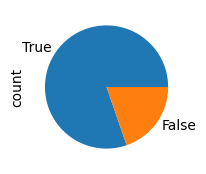

In [36]:
RESULT.value_counts('result').plot.pie(figsize=(2,2));

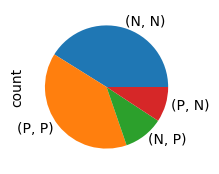

In [37]:
RESULT.value_counts(['prediction','doc_label']).plot.pie(figsize=(2,2));

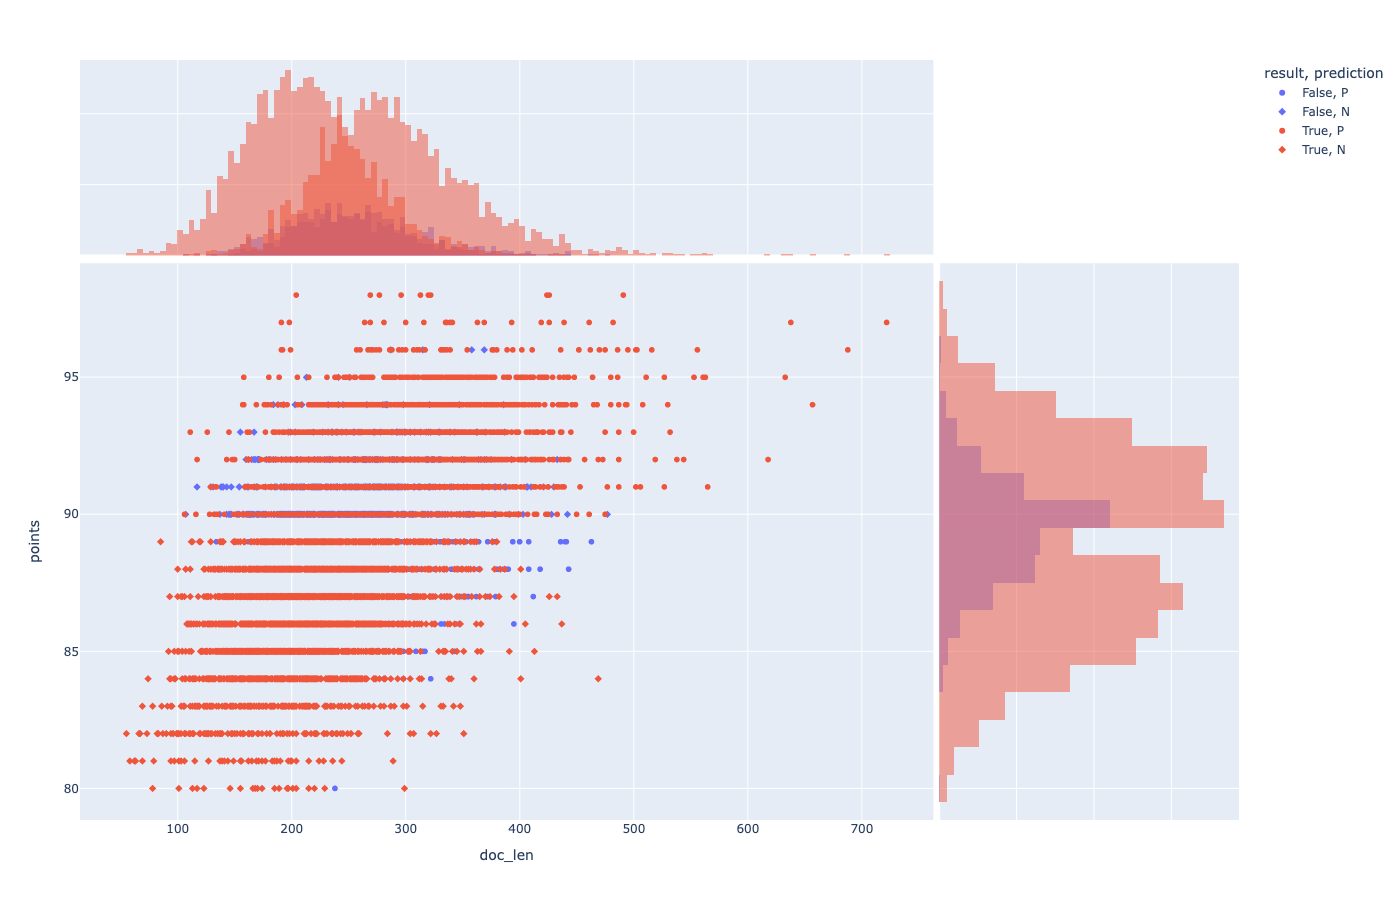

In [38]:
px.scatter(RESULT.join(DOC[['doc_content','points','doc_len']], how='inner').reset_index(), 'doc_len', 'points', color='result', symbol='prediction',
           height=900, width=1000, marginal_x='histogram', marginal_y='histogram')

In [39]:
CM = RESULT.value_counts(['prediction','doc_label']).unstack()

In [40]:
CM

doc_label,N,P
prediction,,
N,3290,839
P,739,3132


In [41]:
def get_results(CM, model_id):
    
    R = pd.DataFrame(index=[model_id])
    R.index.name = 'model_id'
    
    # COUNTS
    R['TN'] = CM.iloc[0,0]   # correct rejections
    R['FN'] = CM.iloc[0,1]   # Type II errors or misses
    R['TP'] = CM.iloc[1,1]   # hits
    R['FP'] = CM.iloc[1,0]   # Type I errors or false alarms
    R['T'] = R.TP + R.TN     # All True
    R['F'] = R.FP + R.FN     # All False
    R['ALL'] = R['T'] + R.F  # All
    
    assert R.ALL.values[0] == CM.sum().sum()
    
    # RATIOS
    R['ACC'] = R['T'] / R.ALL                        # (Simple) Accuracy
    R['TPR'] = R.TP / (R.TP + R.FN)                  # Recall or Sensitivity
    R['TNR'] = R.TN / (R.TN + R.FP)                  # Specificity
    R['PPV'] = R.TP / (R.TP + R.FP)                  # Precision or Positive predictive value 
    R['BA'] = (R.TNR + R.TPR) / 2                    # Balanced Accuracy
    R['F1'] = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN) # F-score where F = 1

    return R

In [42]:
R = get_results(CM, 'svm')

In [43]:
R.T.style.format(precision=3)

model_id,svm
TN,3290.000
FN,839.000
TP,3132.000
FP,739.000
T,6422.000
F,1578.000
ALL,8000.000
ACC,0.803
TPR,0.789
TNR,0.817


# Extract Sentiment

We treat weight as valence.

In [44]:
SALEX = pd.DataFrame(dict(valence=clf.coef_[0]), index=X_test.columns)
SALEX.index.name = 'term_str'
SALEX = SALEX.sort_values('valence')
SALEX['polarity'] = np.sign(SALEX['valence'])

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
scaler = MinMaxScaler(feature_range=(-1, 1))
SALEX['normalized'] = scaler.fit_transform(SALEX[['valence']])

In [47]:
SALEX.sort_values('valence', ascending=False).head(20)

,valence,polarity,normalized
term_str,,,
dollarhide,2.055445,1.0,1.000000
plodding,1.988644,1.0,0.969895
garnachas,1.968114,1.0,0.960643
dâo,1.928953,1.0,0.942994
gathering,1.889004,1.0,0.924991
coiled,1.802714,1.0,0.886103
editors,1.778696,1.0,0.875279
humus,1.765114,1.0,0.869158
singeing,1.744882,1.0,0.860040


In [48]:
SALEX.sort_values('valence', ascending=True).head(20)

,valence,polarity,normalized
term_str,,,
quadra,-2.382433,-1.0,-1.000000
guarantees,-2.110836,-1.0,-0.877601
bourboulenc,-2.039331,-1.0,-0.845376
bedell,-1.923972,-1.0,-0.793387
forewarned,-1.888425,-1.0,-0.777368
dardis,-1.811013,-1.0,-0.742481
vergelegen,-1.766489,-1.0,-0.722415
counties,-1.741566,-1.0,-0.711183
disjointed,-1.737432,-1.0,-0.709320


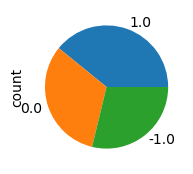

In [49]:
SALEX.polarity.value_counts().plot.pie(figsize=(2,2));

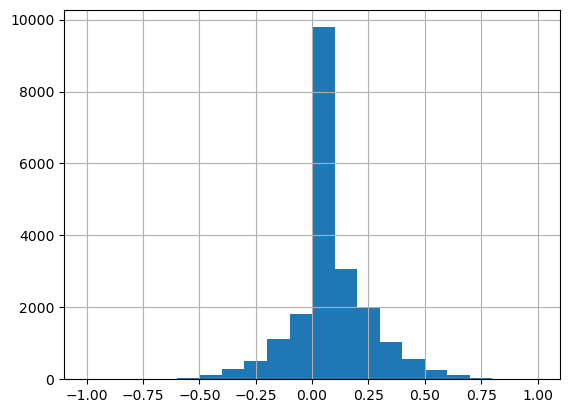

In [50]:
SALEX.normalized.hist(bins=20);

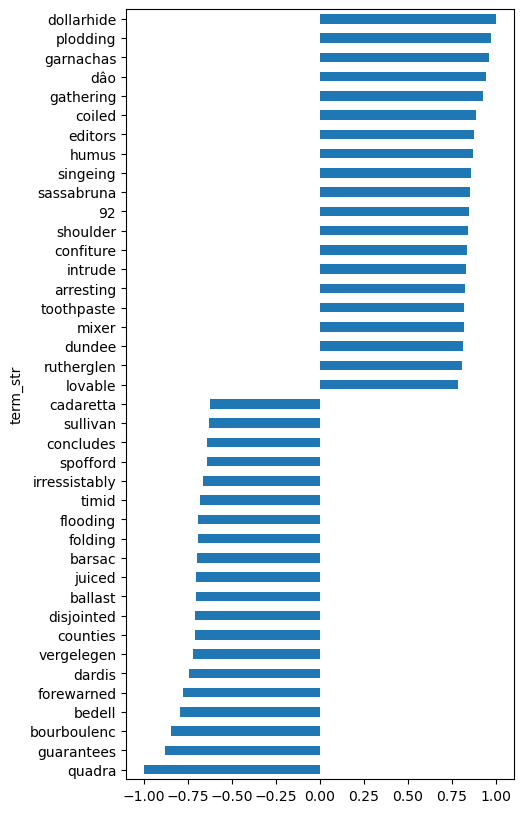

In [51]:
pd.concat([SALEX.normalized.head(20),SALEX.normalized.tail(20)]).plot.barh(figsize=(5,10));

# Save

In [28]:
SALEX.to_csv(f'{data_path}-SVM_SALEX.csv')
R.to_csv(f"{data_path}-SVM_RESULT.csv", index=True)